In [1]:
from utils.loadData import *
from utils.tools import *

import sys
sys.path.append("..")
from resnet import *

loss 0.001, train acc 1.000, test acc 0.813
629.2 examples/sec on cuda:0


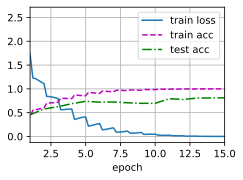

In [8]:
net = get_resnet34()
lr, num_epochs, batch_size = 0.05, 15, 128
train_iter, test_iter = load_data_cifar10(batch_size, resize=224)
train_ch6(net, train_iter, test_iter, num_epochs, lr, try_gpu())

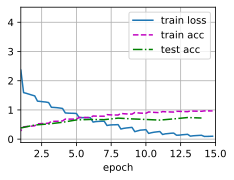

In [ ]:
net = get_resnet50()
lr, num_epochs, batch_size = 0.1, 15, 128
train_iter, test_iter = load_data_cifar10(batch_size, resize=168)
train_ch6(net, train_iter, test_iter, num_epochs, lr, try_gpu())